## B02 - Example usage of SatCLIP to geo-locate Sentinel-2 images

First install and setup the necessary functions.

In [1]:
!rm -r sample_data .config # Empty current directory
!git clone https://github.com/microsoft/satclip.git . # Clone SatCLIP repository

Cloning into '.'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 200 (delta 48), reused 54 (delta 17), pack-reused 95
Receiving objects: 100% (200/200), 12.80 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
!pip install lightning --quiet
!pip install rasterio --quiet
!pip install torchgeo --quiet
!pip install basemap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 948.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Load packages and download a *SatCLIP* model via HuggingFace 🤗.

In [3]:
import sys
sys.path.append('./satclip')

from load import get_satclip
from huggingface_hub import hf_hub_download
import torch
from sklearn.metrics.pairwise import cosine_similarity
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from math import radians, sin, cos, acos
import pandas as pd


device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet50-L40", "satclip-resnet50-l40.ckpt"),
    return_all=True,
    device=device,
)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


satclip-resnet50-l40.ckpt:   0%|          | 0.00/130M [00:00<?, ?B/s]

using pretrained moco resnet50


Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_all_moco/resolve/da4f3c9dbe09272eb902f3b37f46635fa4726879/resnet50_sentinel2_all_moco-df8b932e.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_all_moco-df8b932e.pth
100%|██████████| 90.1M/90.1M [00:01<00:00, 76.1MB/s]


SatCLIP(
  (visual): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

We need a few custom functions for this notebook:
* One to load `.tif` files, which store our Sentinel-2 images (we don't need full dataloaders here).
* One to generate control or reference locations that we want to match our images to.
* And one to compute the Arc distance (great-circle distance / haversine distance) between two longitude/latitude coordinates.

In [4]:
def get_example_image(path, plot=True):
    """
    Loads example Sentinel-2 image from path to tif file
    :param path: Path to image file
    :param plot: If True, will plot an RGB image of the satellite image
    :return: Normalized image as torch tensor
    """
    with rasterio.open(path) as f:
            data = f.read().astype(np.float32)
            image = data / 10000.0
            B10 = np.zeros((1, *image.shape[1:]), dtype=image.dtype)
            image = np.concatenate([image[:10], B10, image[10:]], axis=0)
            image = torch.tensor(image)

            if plot:
                    # Read the first three RGB bands (assuming they are bands 4, 3, and 2)
                    red_band = f.read(4) / 10000.0
                    green_band = f.read(3) / 10000.0
                    blue_band = f.read(2) / 10000.0

                    # Stack the bands to create an RGB image
                    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

                    # Plot the RGB image
                    plt.imshow(rgb_image)
                    plt.title("RGB Sentinel-2 Image")
                    plt.axis('off')  # Hide axes
                    plt.show()

    return image

def generate_control_locations(n):
    """
    Generates n regularly distributed locations on the planet
    :param n: Number of locations to generate
    :return: longitudes, latitudes of generated locations
    """
    import math
    n = n // 2
    # golden ratio
    phi = (1 + math.sqrt(5)) / 2

    lats, lons = [], []

    for i in np.arange(-n, n):
        lat = np.arcsin( (2*i) / (2*n + 1) ) * 180 / np.pi
        lon = (i % phi) * (360 / phi)

        if lon < -180:
            lon += 360
        if lon > 180:
            lon -= 360

        lons.append(lon)
        lats.append(lat)

    return np.stack(lons), np.stack(lats)

def arc_distance(lon1, lat1, lon2, lat2):
    """
    Calculates the great-circle distance between two points on Earth.
    :param lat1: Latitude of location 1 (in degrees)
    :param lon1: Longitude of location 1 (in degrees)
    :param lat2: Latitude of location 2 (in degrees)
    :param lon2: Longitude of location 2 (in degrees)
    :return: Distance in kilometers
    """
    mlat = radians(lat1)
    mlon = radians(lon1)
    plat = radians(lat2)
    plon = radians(lon2)

    dist = 6371.01 * acos(sin(mlat) * sin(plat) + cos(mlat) * cos(plat) * cos(mlon - plon))
    return dist


Now, lets generate our control locations. We choose $100,000$ locations evenly distributed across the planet - but you can set a higher number if you want!

In [5]:
#Generate control locations
control_lons, control_lats = generate_control_locations(100000)
locs = torch.tensor(np.stack([control_lons, control_lats], axis=1)).to(device)
#Get location embeddings of control locations
with torch.no_grad():
  control_embs = model.encode_location(locs)

Now we need Sentinel-2 images and their corresponding locations. We use our *S2-100K* dataset in this example notebook. We can load the `index.csv` file that stores file names and geo-locations of all images in the dataset directly.

In [6]:
#Load S2-100K locations
locations = pd.read_csv('https://satclip.z13.web.core.windows.net/satclip/index.csv')

We provide three example Sentinel-2 images from our dataset in the main *SatCLIP* repository in the `figures/example_s2` folder. You can load these `.tif` files from GitHub directly.

In [7]:
#Path to example images
paths = ['https://github.com/microsoft/satclip/raw/main/figures/example_s2/patch_445.tif',
         'https://github.com/microsoft/satclip/raw/main/figures/example_s2/patch_8845.tif',
         'https://github.com/microsoft/satclip/raw/main/figures/example_s2/patch_33188.tif'
         ]
#Chose one!
path = paths[1]

Let's load and plot an example image!

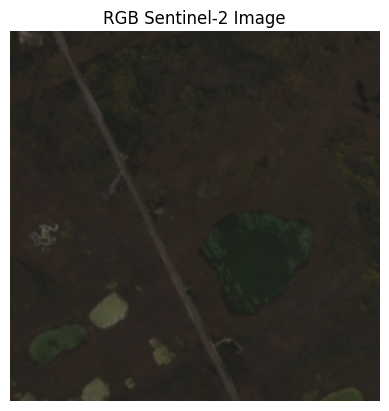

In [8]:
image = get_example_image(path, plot=True)

Can *SatCLIP* correctly place this image on the world map?

First, let's get the location of this specific image from the `index.csv` dataframe so we can compare to the true location.

In [9]:
#Get location corresponding to image from the index dataframe
loc = locations[locations['fn'] == path.split('/')[-1]][['lon','lat']].values

To see what location *SatCLIP* thinks this is, we compute the image embedding using the *SatCLIP* vision encoder.

In [10]:
#Compute image embedding
img_emb = model.visual(image.unsqueeze(0).to(device))

We now obtain the longitude/latitude coordinates of the location with the embedding most closely matching (as measured by cosine similarity) the image embedding.

In [11]:
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim = cosine_similarity(img_emb.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest = np.argmax(cosine_sim)

Let's plot our findings! Looks pretty good. The predicted and true location are less than $100$ kilometers apart.

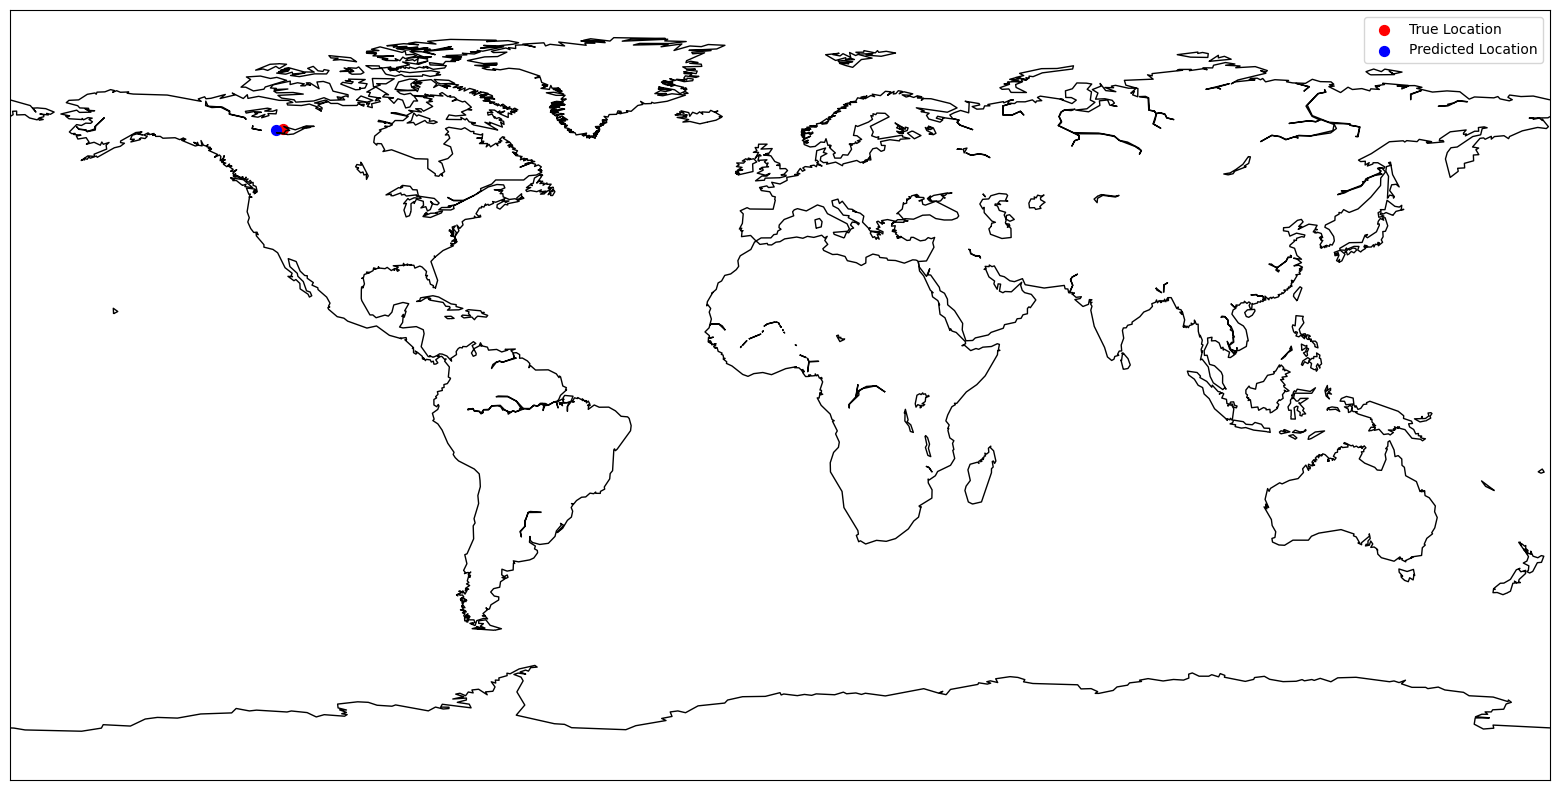

In [12]:
#Plot true and predicted locations
fig, ax = plt.subplots(1,1, figsize=(20, 10))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(loc[0][0], loc[0][1], s=50, c="red", label="True Location")
ax.scatter(control_lons[closest], control_lats[closest], s=50, c="blue", label="Predicted Location")
ax.legend()

In [13]:
distance = arc_distance(loc[0][0], loc[0][1], control_lons[closest], control_lats[closest])
print(f"The distance between the two locations is approximately {distance:.2f} km.")

The distance between the two locations is approximately 81.70 km.


A quick note: The images used in this notebook are all part of the *S2-100K* dataset which was of course used to train *SatCLIP*.